In [1]:
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com



[notice] A new release of pip available: 22.3 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from itertools import product
import random

random.seed(42)

# **Đọc dữ liệu**

In [4]:
ticker_ratio = pd.read_csv('./Data/ticker_ratios.csv')
company_in4 = pd.read_csv('./Data/companies_info.csv')
stock_2010_19 = pd.read_csv('./Data/stock_prices_2010_2019.csv')
stock_2020_25 = pd.read_csv('./Data/stock_prices_2020_2025.csv')

In [5]:
stock_price = pd.concat([stock_2010_19, stock_2020_25], axis=0)

In [6]:
# Chuẩn hóa định dạng ngày tháng
stock_price['date'] = pd.to_datetime(stock_price['date'])

# **Xử lý và phân tích dữ liệu**

In [7]:
company_in4

,ticker,shortName,industry,exchange,establishedYear,foreignPercent
0,A32,Công ty 32,Hàng cá nhân & Gia dụng,UPCOM,2008.0,0.000
1,AAA,An Phát Bioplastics,Hóa chất,HOSE,2007.0,0.021
2,AAH,Than Hợp Nhất,Tài nguyên Cơ bản,UPCOM,2007.0,0.000
3,AAM,Thủy sản Mekong,Thực phẩm và đồ uống,HOSE,2002.0,0.010
4,AAS,Chứng khoán SmartInvest,Dịch vụ tài chính,UPCOM,2006.0,0.001
...,...,...,...,...,...,...
1669,XPH,NaN,NaN,NaN,0.0,0.000
1670,YBC,NaN,NaN,NaN,0.0,0.000
1671,YBM,NaN,NaN,NaN,0.0,0.000
1672,YEG,NaN,NaN,NaN,0.0,0.000


In [8]:
company_in4['exchange'].unique()

array(['UPCOM', 'HOSE', 'HNX', 'OTC', nan, 'NgungGiaoDich'], dtype=object)

**Nhận xét:**

Có thể thấy các mã chứng khoán được thu thập từ đa dạng các sàn khác nhau vậy nên nhóm tập trung phân tích các mã chứng khoán trên sàn chứng khoán phổ biến hiện nay là sàn HOSE

In [9]:
# Lọc dữ liệu sàn HOSE
company_inf4filter = company_in4[company_in4['exchange']=="HOSE"].reset_index(drop=True)
company_inf4filter = company_inf4filter.set_index("ticker")

In [10]:
company_inf4filter

,shortName,industry,exchange,establishedYear,foreignPercent
ticker,,,,,
AAA,An Phát Bioplastics,Hóa chất,HOSE,2007.0,0.021
AAM,Thủy sản Mekong,Thực phẩm và đồ uống,HOSE,2002.0,0.010
AAT,Tập đoàn Tiên Sơn Thanh Hóa,Hàng cá nhân & Gia dụng,HOSE,1995.0,0.008
ABR,Đầu tư Nhãn Hiệu Việt,Hàng & Dịch vụ Công nghiệp,HOSE,2012.0,0.484
ABS,DV Nông nghiệp Bình Thuận,Hóa chất,HOSE,2004.0,0.000
...,...,...,...,...,...
VPI,Đầu tư Văn Phú - Invest,Bất động sản,HOSE,2008.0,0.115
VPS,Thuốc sát trùng Việt Nam,Hóa chất,HOSE,1998.0,0.001
VRC,Bất động sản và Đầu tư VRC,Bất động sản,HOSE,2005.0,0.002


In [11]:
# Các chỉ số tài chính
selected_columns = [
    'priceToEarning',  # P/E
    'priceToBook',     # P/B
    'roe',             # ROE
    'earningPerShare', # EPS
    'currentPayment',  # Current Ratio
    'quickPayment',    # Quick Ratio
    'debtOnEquity',    # D/E Ratio
    'ebitOnInterest',   # Interest Coverage Ratio
    'epsChange',
    'ticker',
    'quarter',
    'year'
]

ticker_ratio = ticker_ratio[selected_columns]

In [12]:
ticker_ratio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19911 entries, 0 to 19910
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   priceToEarning   14543 non-null  float64
 1   priceToBook      14540 non-null  float64
 2   roe              19726 non-null  float64
 3   earningPerShare  19911 non-null  int64  
 4   currentPayment   19591 non-null  float64
 5   quickPayment     19591 non-null  float64
 6   debtOnEquity     19455 non-null  float64
 7   ebitOnInterest   15286 non-null  float64
 8   epsChange        19907 non-null  float64
 9   ticker           19911 non-null  object 
 10  quarter          19911 non-null  int64  
 11  year             19911 non-null  int64  
dtypes: float64(8), int64(3), object(1)
memory usage: 1.8+ MB


In [13]:
ticker_ratio.dropna()

,priceToEarning,priceToBook,roe,earningPerShare,currentPayment,quickPayment,debtOnEquity,ebitOnInterest,epsChange,ticker,quarter,year
13,-10.1,0.6,-0.060,-1117,28.0,7.4,0.0,-106.7,-0.281,AAM,3,2021
14,-6.9,0.6,-0.082,-1555,20.7,5.6,0.0,-146.4,0.183,AAM,2,2021
15,-8.1,0.6,-0.069,-1314,15.6,4.2,0.0,-39.6,0.148,AAM,1,2021
16,-9.8,0.6,-0.059,-1144,11.0,3.3,0.0,-111.6,2.384,AAM,4,2020
17,-34.3,0.6,-0.017,-338,9.9,2.8,0.0,-64.0,-3.348,AAM,3,2020
...,...,...,...,...,...,...,...,...,...,...,...,...
19906,-4.0,1.5,-0.292,-12000,4.2,3.8,0.0,2.4,0.010,YEG,1,2020
19907,-3.1,1.1,-0.291,-11885,2.3,2.1,0.2,-47.0,1.175,YEG,4,2019
19908,-11.0,1.6,-0.127,-5464,2.6,2.4,0.2,-26.8,10.659,YEG,3,2019
19909,-156.8,1.7,-0.017,-468,2.9,2.7,0.2,-20.9,-1.114,YEG,2,2019


In [14]:
len(ticker_ratio['ticker'])

19911

Gộp dữ liệu về chỉ số tài chính và thông tin công ty (ngành)

In [15]:
ticker_ratio_in4 = ticker_ratio.join(company_inf4filter, on='ticker', how="inner")

In [16]:
ticker_ratio_in4.head()

,priceToEarning,priceToBook,roe,earningPerShare,currentPayment,quickPayment,debtOnEquity,ebitOnInterest,epsChange,ticker,quarter,year,shortName,industry,exchange,establishedYear,foreignPercent
0,-11.7,0.4,-0.032,-602,33.6,15.5,0.0,NaN,0.179,AAM,4,2024,Thủy sản Mekong,Thực phẩm và đồ uống,HOSE,2002.0,0.01
1,-15.2,0.4,-0.027,-511,13.8,5.3,0.0,NaN,0.051,AAM,3,2024,Thủy sản Mekong,Thực phẩm và đồ uống,HOSE,2002.0,0.01
2,-17.0,0.4,-0.025,-486,12.7,3.8,0.0,NaN,0.953,AAM,2,2024,Thủy sản Mekong,Thực phẩm và đồ uống,HOSE,2002.0,0.01
3,-37.4,0.5,-0.013,-248,18.7,4.9,0.0,NaN,-4.700,AAM,1,2024,Thủy sản Mekong,Thực phẩm và đồ uống,HOSE,2002.0,0.01
4,138.6,0.5,0.003,67,19.0,5.1,0.0,NaN,-0.841,AAM,4,2023,Thủy sản Mekong,Thực phẩm và đồ uống,HOSE,2002.0,0.01


In [17]:
len(ticker_ratio_in4['ticker'])

2823

## Ý nghĩa những chỉ số tài chính phổ biến

**Chỉ số định giá cổ phiếu**


*   PricetoEarning (P/E) – Chỉ số giá trên lợi nhuận, quan trọng để đánh giá mức định giá cổ phiếu.
*   PricetoBook (P/B) – Chỉ số giá trên giá trị sổ sách, giúp đánh giá giá trị cổ phiếu so với tài sản ròng.



**Chỉ số lợi nhuận**


*   ROE (Return On Equity) – Lợi nhuận trên vốn chủ sở hữu, đo lường hiệu quả sử dụng vốn.
*   earningPerShare (EPS) – Lợi nhuận trên mỗi cổ phiếu, phản ánh lợi nhuận dành cho cổ đông.



**Chỉ số đo lường khả năng thanh toán**

*   CurrentPayment – Khả năng thanh toán hiện hành (Current Ratio), đo lường khả năng trả nợ ngắn hạn.
*   QuickPayment – Khả năng thanh toán nhanh (Quick Ratio), đo lường khả năng trả nợ không cần bán hàng tồn kho.



**Chỉ số rủi ro tài chính**


*   DebtOnEquity (D/E) – Nợ trên vốn chủ sở hữu, đo lường mức độ nợ so với vốn chủ.
*   ebitOnInterest (Interest Coverage Ratio) – Khả năng trả lãi vay, đánh giá khả năng doanh nghiệp trả lãi vay.



In [18]:
df = ticker_ratio_in4

***Chú ý:***

Để tìm ngưỡng chỉ số tài chính hợp lý, nhóm thực hiện chia dữ liệu thành 3 phần (train, validation, test) để hyper-param

In [19]:
# Tách dữ liệu
df_pre_2022 = df[df['year'] < 2022].reset_index(drop=True) # Dữ liệu train để chọn tham số
df_2022_2023 = df[(df['year'] >= 2022) & (df['year'] <= 2023)].reset_index(drop=True) # Dữ liệu validation xem các mã đó có thực sự tốt lên
df_2023_2024 = df[(df['year'] >= 2023) & (df['year'] <= 2024)].reset_index(drop=True) # Dữ liệu test sau khi đã chọn được tham số tốt nhắt

## Lọc ra các mã cổ phiếu tiềm năng dựa trên ngưỡng chỉ số tài chính

'priceToEarning' < trung bình ngành: Định giá thấp hơn ngành.

'debtOnEquity' < 1: Mức nợ thấp, tài chính ổn định, cho thấy doanh nghiệp sử dụng vốn chủ sở hữu nhiều hơn nợ vay, phản ánh sự ổn định tài chính và khả năng tự chủ cao hơn (Tham khảo tại [link text](https://www.vietcap.com.vn/kien-thuc/ty-le-no-tren-von-chu-so-huu-d-e-ratio-co-y-nghia-gi?utm_source=chatgpt.com))

'roe' > 0.14: Có thể chấp nhận được (Tham khảo tại [link text](https://yuanta.com.vn/tin-tuc/chi-so-roa-va-roe-va-nhung-thong-tin-co-ban-trong-chung-khoan))

In [20]:
# Hàm lọc danh sách mã chứng khoán dựa trên các tiêu chí phân tích cơ bản, tăng trưởng và định giá
def hyper_param_chosen(df_selection, pe_thr: int = 15, quater_change: int = 2, pb_thr: float = 1.5, roe_thr : float = 0.14, debtOnEquity_thr: int = 1):
  '''
      Hàm này giúp chọn ra các cổ phiếu tốt dựa trên: Khả năng sinh lời cao (ROE cao)
                                                      Nợ thấp (Tỷ lệ Nợ/Vốn chủ sở hữu thấp)
                                                      Có sự tăng trưởng EPS trong ít nhất quater_change quý gần đây
                                                      Định giá thấp hơn mức trung bình của ngành

      Tham số truyền vào: - df_selection: DataFrame chứa dữ liệu tài chính của các công ty
                          - Các tham số lọc dữ liệu: + pe_thr: Ngưỡng tối đa cho chỉ số P/E
                                                     + quarter_change: Số quý tối thiểu có tăng trưởng EPS dương
                                                     + pb_thr: Ngưỡng tối đa cho chỉ số P/B
                                                     + roe_thr = 0.14: Ngưỡng tối thiểu cho ROE
                                                     + debtOnEquity_thr = 1: Ngưỡng tối đa cho tỷ lệ Nợ/Vốn chủ sở hữu

      Đầu ra: selected_tickers: Danh sách mã chứng khoán thỏa mãn tất cả điều kiện lọc.
  '''

  # Bước 1: Phân tích cơ bản (trước 2022)
  fundamental_filter = df_selection[(df_selection['priceToEarning'] < pe_thr) &
                                  (df_selection['priceToBook'] < pb_thr) &
                                  (df_selection['roe'] > roe_thr) &
                                  (df_selection['debtOnEquity'] < debtOnEquity_thr)].reset_index(drop=True)

  # Bước 2: Phân tích theo thời gian (trước 2022): Xem trong khoảng thời gian này có tăng trưởng không
  fundamental_filter = fundamental_filter.sort_values(['ticker', 'year', 'quarter']).reset_index(drop=True)
  time_series_filter = fundamental_filter.groupby('ticker').apply(
      lambda x: (x['epsChange'] > 0).rolling(quater_change).sum().max() >= 1
  )
  time_series_stocks = time_series_filter[time_series_filter].index
  filtered_by_time = fundamental_filter[fundamental_filter['ticker'].isin(time_series_stocks)]

  # Bước 3: Mô hình định giá (trước 2022): PE < PE ngành
  industry_pe = df_selection.groupby('industry')['priceToEarning'].mean()  # Dùng dữ liệu trước 2022 để tính trung bình ngành
  final_selection_pre_2022 = filtered_by_time[
      filtered_by_time['priceToEarning'] < filtered_by_time['industry'].map(industry_pe)
  ]
  selected_tickers = final_selection_pre_2022['ticker'].unique()
  return selected_tickers

In [21]:
# Sau khi chọn mã (theo tham số) từ hàm hyper_param_chosen -> đánh giá xem mã đó có tăng trưởng ko và chọn ra các mã tăng trưởng
def validation_tickers(ticker_selected, df_test):
  '''
      Tham số truyền vào: ticker_selected: Danh sách mã cổ phiếu được chọn từ hàm hyper_param_chosen
                          df_test: DataFrame chứa dữ liệu tài chính của các mã cổ phiếu (dữ liệu kiểm tra)

      Đầu ra: all_good: Số lượng mã cổ phiếu đạt tất cả các tiêu chí
              per75_cent: Số lượng mã đạt ít nhất 3/4 tiêu chí (Vì một mã cổ phiếu đạt ít nhất 3/4 tiêu chí, nó vẫn có tiềm năng đáng cân nhắc)

  '''

  df_test = df_test[df_test['ticker'].isin(ticker_selected)].reset_index(drop=True)
  # 1. Tăng trưởng (EPS Change): chỉ cần 2 quý liên tiếp tăng trưởng
  eps_trend = df_test.groupby('ticker').apply(
      lambda x: (x['epsChange'] > 0).rolling(2).sum().max() >= 2
  )
  eps_avg = df_test.groupby('ticker')['epsChange'].mean() > 0
  growth_potential = eps_trend | eps_avg

  # 2. Hiệu quả hoạt động (ROE)
  roe_avg = df_test.groupby('ticker')['roe'].mean()
  roe_potential = roe_avg > 0.14

  # 3. Định giá hợp lý (P/E so với ngành)
  industry_pe = df_test.groupby('industry')['priceToEarning'].mean()
  pe_avg = df_test.groupby('ticker')['priceToEarning'].mean()
  temp_df = df_test[['ticker', 'industry']].drop_duplicates().set_index('ticker')
  pe_comparison = pe_avg < temp_df['industry'].map(industry_pe)

  # 4. Tính ổn định tài chính (Debt/Equity)
  debt_avg = df_test.groupby('ticker')['debtOnEquity'].mean()
  debt_potential = debt_avg < 1


  # Tổng hợp
  # Các mã thỏa mãn tất cả tiêu chí
  potential_stocks = growth_potential & roe_potential & pe_comparison & debt_potential
  all_good = len(potential_stocks[potential_stocks].index.tolist())

  # Các mã thỏa mãn ít nhất 3/4 tiêu chí
  criteria_met = pd.DataFrame({
      'growth': growth_potential,
      'roe': roe_potential,
      'pe': pe_comparison,
      'debt': debt_potential
  })
  flexible_potential = criteria_met.sum(axis=1) >= 3
  per75_cent = len(flexible_potential[flexible_potential].index.tolist())
  return all_good, per75_cent

In [22]:
# Hàm tìm kiếm tham số tối ưu cho hàm hyper_param_chosen
def grid_search_hyperparams(df_selection):
    param_grid = {
        'pe_thr': [10, 15, 20, 30, 40],            # P/E threshold
        'pb_thr': [1.0, 1.5, 3, 6],           # P/B threshold
        'quater_change': [1, 2, 3],
        'roe_thr': [0.15, 0.2, 0.25, 0.3, 0.5],      # ROE threshold
        'debtOnEquity_thr': [0.5, 1.0, 2.0, 5.0]  # Debt/Equity threshold
    }

    # Tạo danh sách tất cả tổ hợp tham số
    keys, values = zip(*param_grid.items())
    param_combinations = [dict(zip(keys, v)) for v in product(*values)]

    # Lưu kết quả
    results = []

    # Duyệt qua từng tổ hợp tham số
    for params in param_combinations:
        selected_tickers = hyper_param_chosen(
            df_selection=df_selection,
            pe_thr=params['pe_thr'],
            quater_change=params['quater_change'],
            pb_thr=params['pb_thr'],
            roe_thr=params['roe_thr'],
            debtOnEquity_thr=params['debtOnEquity_thr']
        )
        num_stocks = len(selected_tickers)
        all_good, per75_cent = validation_tickers(selected_tickers, df_2022_2023)
        # Lưu kết quả: tổ hợp tham số và số mã chọn được
        results.append({
            'pe_thr': params['pe_thr'],
            'pb_thr': params['pb_thr'],
            'quater_change': params['quater_change'],
            'roe_thr': params['roe_thr'],
            'debtOnEquity_thr': params['debtOnEquity_thr'],
            'num_stocks': num_stocks,
            'all_good': all_good,
            'per75_cent': per75_cent
        })

    # Chuyển kết quả thành DataFrame
    results_df = pd.DataFrame(results)

    # Tìm tổ hợp tốt nhất (ví dụ: số mã lớn nhất hoặc số mã hợp lý trong khoảng mong muốn)
    best_result = results_df.loc[results_df['all_good'].idxmax()]  # Tối đa hóa số mã
    print("\nTổ hợp tham số tốt nhất (tối đa hóa số mã):")
    print(best_result)

    return results_df

In [23]:
# Chạy Grid Search
results_df = grid_search_hyperparams(df_pre_2022)


Tổ hợp tham số tốt nhất (tối đa hóa số mã):
pe_thr              15.00
pb_thr               3.00
quater_change        1.00
roe_thr              0.15
debtOnEquity_thr     2.00
num_stocks          32.00
all_good             6.00
per75_cent          15.00
Name: 362, dtype: float64


In [24]:
results_df.head()

,pe_thr,pb_thr,quater_change,roe_thr,debtOnEquity_thr,num_stocks,all_good,per75_cent
0,10,1.0,1,0.15,0.5,11,2,3
1,10,1.0,1,0.15,1.0,16,3,7
2,10,1.0,1,0.15,2.0,17,3,7
3,10,1.0,1,0.15,5.0,18,3,7
4,10,1.0,1,0.20,0.5,6,0,1


**Nhận xét**

Có thể thấy có nhiều bộ tham số đưa ra 6 mã thỏa mãn các tiêu chí, tuy nhiên để chắc chẳn hơn ta sẽ lấy bộ tham số làm cho số lượng mã thỏa mãn 3/4 tiêu chí nhiều nhất bằng lấy tỉ lệ số lượng mã thỏa mãn 3/4 tiêu chí (per75_cent) so với tổng số mã (num_stocks) là lớn nhất

In [25]:
hyper_df = results_df[results_df['all_good'] == 6].reset_index(drop=True)
hyper_df['ratio_check'] = hyper_df['per75_cent']/hyper_df['num_stocks']
max_ratio = hyper_df['ratio_check'].max()
hyper_df = hyper_df[hyper_df['ratio_check'] == max_ratio]
hyper_df

,pe_thr,pb_thr,quater_change,roe_thr,debtOnEquity_thr,num_stocks,all_good,per75_cent,ratio_check
0,15,3.0,1,0.15,2.0,32,6,15,0.46875
2,15,6.0,1,0.15,2.0,32,6,15,0.46875
4,20,3.0,1,0.15,2.0,32,6,15,0.46875
6,20,6.0,1,0.15,2.0,32,6,15,0.46875
8,30,3.0,1,0.15,2.0,32,6,15,0.46875
10,30,6.0,1,0.15,2.0,32,6,15,0.46875
12,40,3.0,1,0.15,2.0,32,6,15,0.46875
14,40,6.0,1,0.15,2.0,32,6,15,0.46875


In [26]:
# Đánh giá lại danh sách cổ phiếu đã chọn
def take_ticker(ticker_selected, df_test):
  df_test = df_test[df_test['ticker'].isin(ticker_selected)].reset_index(drop=True)
  # 1. Tăng trưởng (EPS Change): chỉ cần 2 quý liên tiếp tăng trưởng
  eps_trend = df_test.groupby('ticker').apply(
      lambda x: (x['epsChange'] > 0).rolling(2).sum().max() >= 2
  )
  eps_avg = df_test.groupby('ticker')['epsChange'].mean() > 0
  growth_potential = eps_trend | eps_avg

  # 2. Hiệu quả hoạt động (ROE)
  roe_avg = df_test.groupby('ticker')['roe'].mean()
  roe_potential = roe_avg > 0.15

  # 3. Định giá hợp lý (P/E so với ngành)
  industry_pe = df_test.groupby('industry')['priceToEarning'].mean()
  pe_avg = df_test.groupby('ticker')['priceToEarning'].mean()
  temp_df = df_test[['ticker', 'industry']].drop_duplicates().set_index('ticker')
  pe_comparison = pe_avg < temp_df['industry'].map(industry_pe)

  # 4. Tính ổn định tài chính (Debt/Equity)
  debt_avg = df_test.groupby('ticker')['debtOnEquity'].mean()
  debt_potential = debt_avg < 1

  # Tổng hợp tiềm năng
  # Thỏa mãn tất cả tiêu chí
  potential_stocks = growth_potential & roe_potential & pe_comparison & debt_potential
  all_good = potential_stocks[potential_stocks].index.tolist()

  # Thỏa mãn ít nhất 3/4 tiêu chí
  criteria_met = pd.DataFrame({
      'growth': growth_potential,
      'roe': roe_potential,
      'pe': pe_comparison,
      'debt': debt_potential
  })
  flexible_potential = criteria_met.sum(axis=1) >= 3
  per75_cent = flexible_potential[flexible_potential].index.tolist()
  return all_good, per75_cent

In [27]:
ticker_result = []
counting_dict = {}
for index, row in hyper_df.iterrows():
  ticker_selected = hyper_param_chosen(df_pre_2022, pe_thr = row['pe_thr'], quater_change = int(row['quater_change']), pb_thr = row['pb_thr'], roe_thr = row['roe_thr'], debtOnEquity_thr = row['debtOnEquity_thr'])
  all_good, third_part_four = take_ticker(ticker_selected, df_2022_2023)
  ticker_result.extend(third_part_four)

  for elm in ticker_selected:
    if elm not in third_part_four:
      if elm not in counting_dict.keys():
        counting_dict[elm] = 1
      else:
        counting_dict[elm] += 1

In [28]:
ticker_result.extend(list(counting_dict.keys()))

In [29]:
ticker_result = list(set(ticker_result))

In [30]:
tickers_to_remove = {'ICT', 'ILB', 'FIR'}
ticker_result = [ticker for ticker in ticker_result if ticker not in tickers_to_remove]

In [31]:
len(ticker_result)

29

In [32]:
# ticker_result.to_csv("ticker_result.csv", index=False)

# # Tải file về
# files.download("ticker_result.csv")

In [33]:
ticker_result

['FDC',
 'BTT',
 'KDC',
 'PAN',
 'KPF',
 'C32',
 'OPC',
 'DTL',
 'VPS',
 'IJC',
 'ELC',
 'IDI',
 'BWE',
 'DXG',
 'ITD',
 'BMP',
 'VRC',
 'FIT',
 'OGC',
 'VPD',
 'KHP',
 'DVP',
 'BTP',
 'KDH',
 'DRL',
 'VSC',
 'FCN',
 'DSN',
 'DRC']

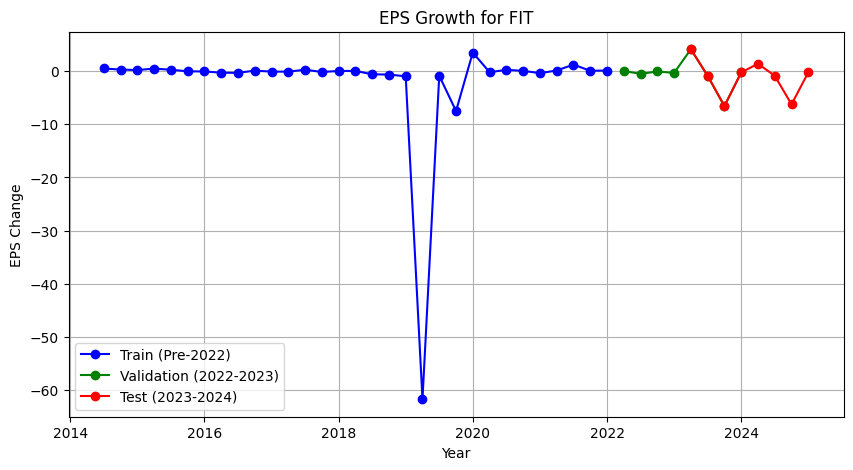

In [128]:
# Visual 1 mã bất kỳ xem biến thiên về sự tăng trưởng
def plot_ticker_growth(ticker, df_pre_2022, df_2022_2023, df_2023_2024):
    # Lọc dữ liệu theo mã cổ phiếu
    df_train = df_pre_2022[df_pre_2022['ticker'] == ticker]
    df_valid = df_2022_2023[df_2022_2023['ticker'] == ticker]
    df_test = df_2023_2024[df_2023_2024['ticker'] == ticker]

    # Vẽ biểu đồ
    plt.figure(figsize=(10, 5))

    # Vẽ đường biểu diễn epsChange theo thời gian
    plt.plot(df_train['year'] + df_train['quarter']/4, df_train['epsChange'], 'bo-', label='Train (Pre-2022)')
    plt.plot(df_valid['year'] + df_valid['quarter']/4, df_valid['epsChange'], 'go-', label='Validation (2022-2023)')
    plt.plot(df_test['year'] + df_test['quarter']/4, df_test['epsChange'], 'ro-', label='Test (2023-2024)')

    # Thêm tiêu đề và nhãn
    plt.xlabel("Year")
    plt.ylabel("EPS Change")
    plt.title(f"EPS Growth for {ticker}")
    plt.legend()
    plt.grid()
    plt.show()

# Gọi hàm vẽ cho một mã trong ticker_result
example_ticker = ticker_result[1]  # Chọn một mã bất kỳ
plot_ticker_growth(example_ticker, df_pre_2022, df_2022_2023, df_2023_2024)


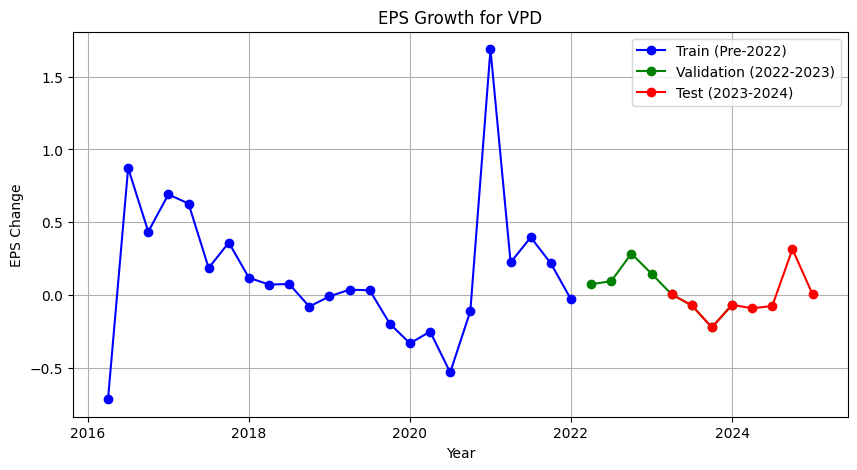

In [139]:
# Visual 1 mã bất kỳ xem biến thiên về sự tăng trưởng
def plot_ticker_growth(ticker, df_pre_2022, df_2022_2023, df_2023_2024):
    # Lọc dữ liệu theo mã cổ phiếu
    df_train = df_pre_2022[df_pre_2022['ticker'] == ticker]
    df_valid = df_2022_2023[df_2022_2023['ticker'] == ticker]
    df_test = df_2023_2024[df_2023_2024['ticker'] == ticker]

    # Vẽ biểu đồ
    plt.figure(figsize=(10, 5))

    # Vẽ đường biểu diễn epsChange theo thời gian
    plt.plot(df_train['year'] + df_train['quarter']/4, df_train['epsChange'], 'bo-', label='Train (Pre-2022)')
    plt.plot(df_valid['year'] + df_valid['quarter']/4, df_valid['epsChange'], 'go-', label='Validation (2022-2023)')
    plt.plot(df_test['year'] + df_test['quarter']/4, df_test['epsChange'], 'ro-', label='Test (2023-2024)')

    # Thêm tiêu đề và nhãn
    plt.xlabel("Year")
    plt.ylabel("EPS Change")
    plt.title(f"EPS Growth for {ticker}")
    plt.legend()
    plt.grid()
    plt.show()

# Gọi hàm vẽ cho một mã trong ticker_result
example_ticker = ticker_result[3]  # Chọn một mã bất kỳ
plot_ticker_growth(example_ticker, df_pre_2022, df_2022_2023, df_2023_2024)


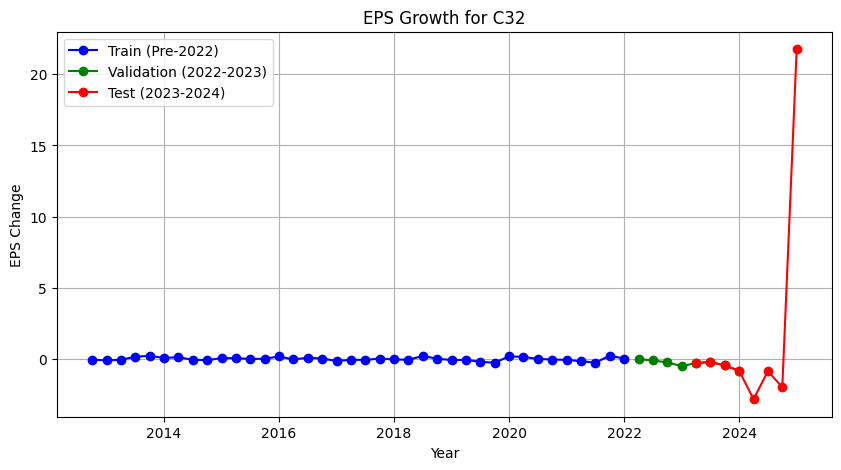

In [129]:
# Visual 1 mã bất kỳ xem biến thiên về sự tăng trưởng
def plot_ticker_growth(ticker, df_pre_2022, df_2022_2023, df_2023_2024):
    # Lọc dữ liệu theo mã cổ phiếu
    df_train = df_pre_2022[df_pre_2022['ticker'] == ticker]
    df_valid = df_2022_2023[df_2022_2023['ticker'] == ticker]
    df_test = df_2023_2024[df_2023_2024['ticker'] == ticker]

    # Vẽ biểu đồ
    plt.figure(figsize=(10, 5))

    # Vẽ đường biểu diễn epsChange theo thời gian
    plt.plot(df_train['year'] + df_train['quarter']/4, df_train['epsChange'], 'bo-', label='Train (Pre-2022)')
    plt.plot(df_valid['year'] + df_valid['quarter']/4, df_valid['epsChange'], 'go-', label='Validation (2022-2023)')
    plt.plot(df_test['year'] + df_test['quarter']/4, df_test['epsChange'], 'ro-', label='Test (2023-2024)')

    # Thêm tiêu đề và nhãn
    plt.xlabel("Year")
    plt.ylabel("EPS Change")
    plt.title(f"EPS Growth for {ticker}")
    plt.legend()
    plt.grid()
    plt.show()

# Gọi hàm vẽ cho một mã trong ticker_result
example_ticker = ticker_result[0]  # Chọn một mã bất kỳ
plot_ticker_growth(example_ticker, df_pre_2022, df_2022_2023, df_2023_2024)


# **Visualize**

In [130]:
df_grid = results_df

# Thiết lập kiểu trực quan hóa
plt.style.use('tableau-colorblind10')

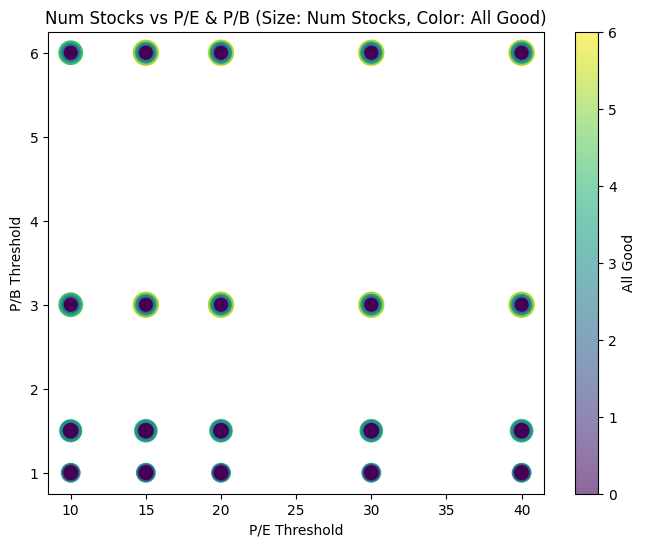

In [131]:
# 1. Scatter Plot: num_stocks vs pe_thr & pb_thr (màu: all_good)
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df_grid['pe_thr'], df_grid['pb_thr'], s=df_grid['num_stocks']*10,
                      c=df_grid['all_good'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='All Good')
plt.xlabel('P/E Threshold')
plt.ylabel('P/B Threshold')
plt.title('Num Stocks vs P/E & P/B (Size: Num Stocks, Color: All Good)')
plt.show()

<ipython-input-132-6aebb09f1f60>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='quater_change', y='num_stocks', data=df_grid, estimator='mean', ci=None)


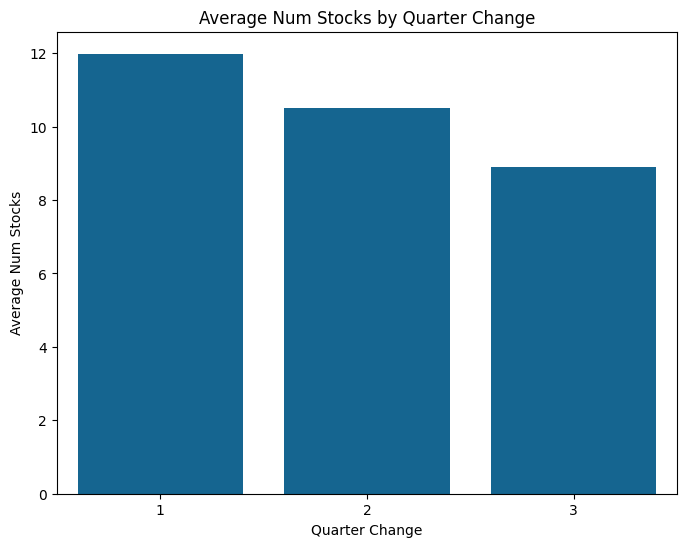

In [132]:
# 2. Bar Plot: num_stocks trung bình theo quater_change
plt.figure(figsize=(8, 6))
sns.barplot(x='quater_change', y='num_stocks', data=df_grid, estimator='mean', ci=None)
plt.xlabel('Quarter Change')
plt.ylabel('Average Num Stocks')
plt.title('Average Num Stocks by Quarter Change')
plt.show()

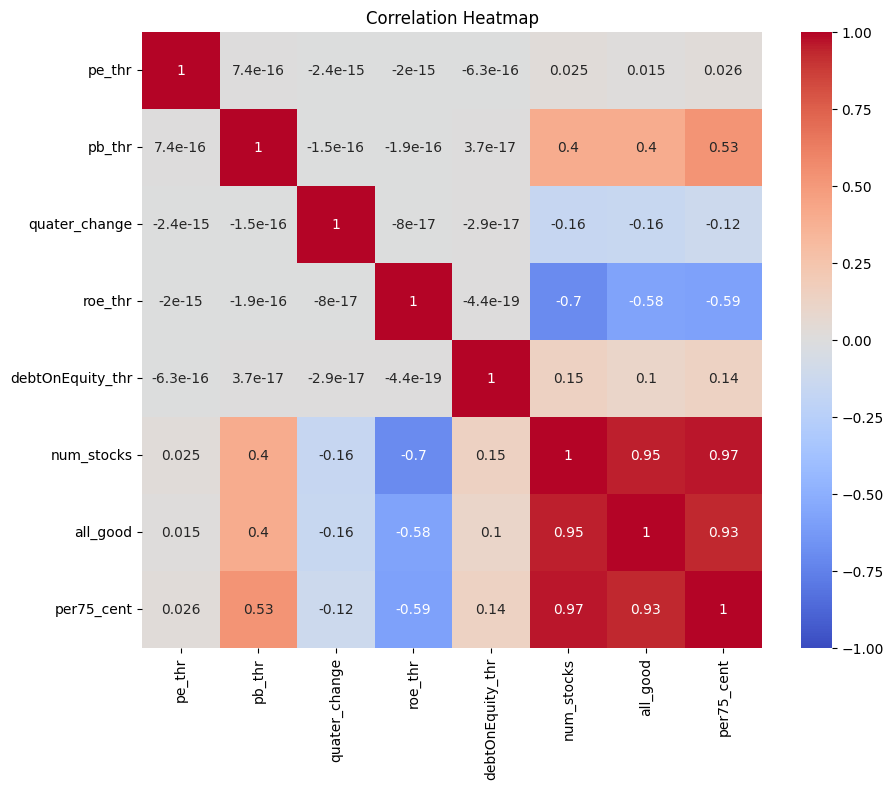

In [133]:
# 3. Heatmap: Tương quan giữa các cột
plt.figure(figsize=(10, 8))
correlation_matrix = df_grid.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

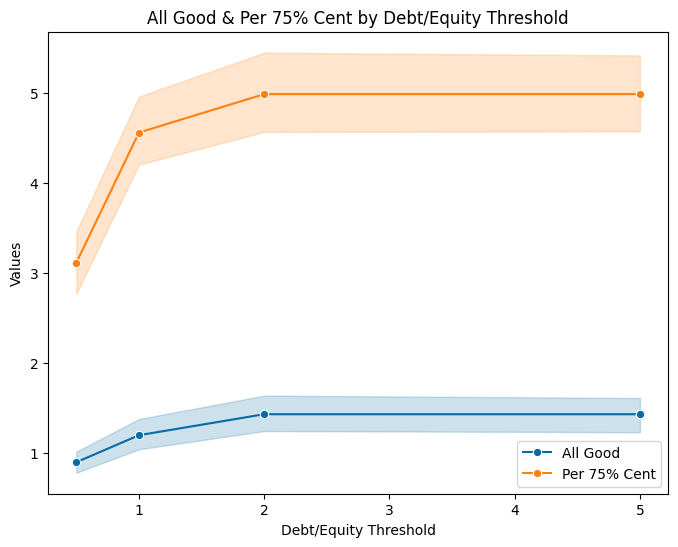

In [134]:
# 5. Line Plot: all_good và per75_cent theo debtOnEquity_thr
plt.figure(figsize=(8, 6))
sns.lineplot(x='debtOnEquity_thr', y='all_good', data=df_grid, label='All Good', marker='o')
sns.lineplot(x='debtOnEquity_thr', y='per75_cent', data=df_grid, label='Per 75% Cent', marker='o')
plt.xlabel('Debt/Equity Threshold')
plt.ylabel('Values')
plt.title('All Good & Per 75% Cent by Debt/Equity Threshold')
plt.legend()
plt.show()

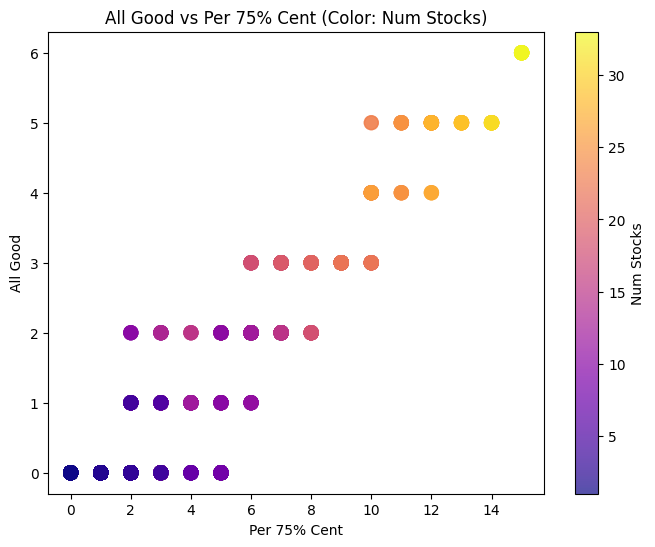

In [135]:
# 6. Scatter Plot: all_good vs per75_cent (màu: num_stocks)
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df_grid['per75_cent'], df_grid['all_good'],
                      c=df_grid['num_stocks'], cmap='plasma', s=100, alpha=0.7)
plt.colorbar(scatter, label='Num Stocks')
plt.xlabel('Per 75% Cent')
plt.ylabel('All Good')
plt.title('All Good vs Per 75% Cent (Color: Num Stocks)')
plt.show()

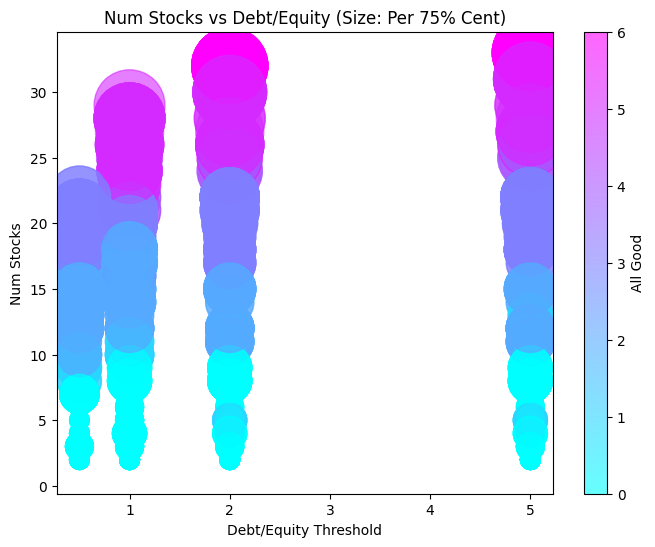

In [136]:
# 8. Scatter Plot: num_stocks vs debtOnEquity_thr (kích thước: per75_cent)
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df_grid['debtOnEquity_thr'], df_grid['num_stocks'],
                      s=df_grid['per75_cent']*200, c=df_grid['all_good'], cmap='cool', alpha=0.6)
plt.colorbar(scatter, label='All Good')
plt.xlabel('Debt/Equity Threshold')
plt.ylabel('Num Stocks')
plt.title('Num Stocks vs Debt/Equity (Size: Per 75% Cent)')
plt.show()